In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, accuracy_score, roc_auc_score, 
                             roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve,hamming_loss)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import re
import os

# Create models folder
os.makedirs("models", exist_ok=True)

# check NLTK
try:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')
    nltk.download('omw-1.4')
    nltk.download('punkt_tab')
except:
    print("NLTK downloads completed or encountered an error")

# Load the dataset
df = pd.read_csv("train.csv")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
# 1. Multi-Label Targets -> Binary
toxicity_columns = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
for col in toxicity_columns:
    df[col] = (df[col] > 0).astype(int)

target_labels = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']
y = df[target_labels]

In [3]:
# 2. Create a "Master" Toxic Indicator
df['is_toxic'] = (y.sum(axis=1) > 0).astype(int)
print("Original Dataset Balance:")
print(f"Non-Toxic comments: {(df['is_toxic'] == 0).sum()}")
print(f"Toxic comments: {(df['is_toxic'] == 1).sum()}\n")

Original Dataset Balance:
Non-Toxic comments: 1270244
Toxic comments: 534630



In [4]:
# 3. Enhanced Text Preprocessing with NLTK
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove numbers and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    try:
        tokens = word_tokenize(text)
    except:
        tokens = text.split()
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and len(token) > 2]
    
    return ' '.join(tokens)

print("Preprocessing text data...")
df['processed_text'] = df['comment_text'].fillna("").apply(preprocess_text)

Preprocessing text data...


In [5]:
# 4. Sampling to Balance the Dataset
df_non_toxic = df[df['is_toxic'] == 0]
df_toxic = df[df['is_toxic'] == 1]

# Undersample Non-Toxic
non_toxic_sample_ratio = 0.2
df_non_toxic_sampled = df_non_toxic.sample(frac=non_toxic_sample_ratio, random_state=42)

# Oversample Rare Toxic Types
toxic_counts = df_toxic[target_labels].sum()
rarest_toxic_type = toxic_counts.idxmin()
rarest_count = toxic_counts.min()

print("Toxic Subtype Counts (Before Oversampling):")
print(toxic_counts)
print(f"\nRarest type is '{rarest_toxic_type}' with {rarest_count} samples.\n")

# For each toxic subtype, oversample its examples
dfs_to_oversample = []
for label in target_labels:
    df_label = df_toxic[df_toxic[label] == 1].copy()
    current_count = len(df_label)
    
    n_samples_needed = rarest_count
    
    if current_count < n_samples_needed:
        df_label_oversampled = df_label.sample(n=n_samples_needed, replace=True, random_state=42)
        dfs_to_oversample.append(df_label_oversampled)
    else:
        dfs_to_oversample.append(df_label.sample(n=n_samples_needed, random_state=42))

# Combine all the oversampled toxic class DataFrames
df_toxic_oversampled = pd.concat(dfs_to_oversample)

# Create the Final Balanced Dataset
df_balanced = pd.concat([df_non_toxic_sampled, df_toxic_oversampled])
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Dataset Composition:")
print(f"Total samples: {len(df_balanced)}")
print(f"Non-Toxic samples: {len(df_balanced[df_balanced['is_toxic'] == 0])}")
print(f"Toxic samples: {len(df_balanced[df_balanced['is_toxic'] == 1])}\n")

Toxic Subtype Counts (Before Oversampling):
severe_toxicity    104636
obscene            147175
threat             106929
insult             454539
identity_attack    218552
dtype: int64

Rarest type is 'severe_toxicity' with 104636 samples.

Balanced Dataset Composition:
Total samples: 777229
Non-Toxic samples: 254049
Toxic samples: 523180



In [6]:
# 5. Prepare Features and Target for the Balanced Dataset
X_balanced = df_balanced['processed_text']
y_balanced = df_balanced[target_labels]

# Vectorize the text with enhanced parameters
vectorizer = TfidfVectorizer(
    stop_words='english', 
    max_features=10000, 
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.9
)
X_tfidf = vectorizer.fit_transform(X_balanced)

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_balanced, test_size=0.2, random_state=42)

In [7]:
# 7. Models Training
models = {
    'Naive Bayes': OneVsRestClassifier(MultinomialNB()),
    'SVM': OneVsRestClassifier(LinearSVC(class_weight='balanced', random_state=42, dual=False))
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    # Handle models with different prediction methods
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
    else:
        # For SVM which doesn't have predict_proba by default
        y_pred_proba = None
    
    y_pred = model.predict(X_test)
    
    # Store results and models
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    # Save each model
    joblib.dump(model, f"models/{name.lower().replace(' ', '_')}_model.pkl")
    print(f"{name} model saved!\n")

# Save the vectorizer
joblib.dump(vectorizer, "models/vectorizer.pkl")
print("Vectorizer saved!")

Training Naive Bayes...
Naive Bayes model saved!

Training SVM...
SVM model saved!

Vectorizer saved!


In [8]:
# 8. Training Results
print("="*50)
print("MODEL EVALUATION")
print("="*50)

for name, result in results.items():
    y_pred = result['y_pred']
    y_pred_proba = result['y_pred_proba']
    
    print(f"\n{name} Performance:")
    print("-" * 30)
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Hamming Loss
    h_loss = hamming_loss(y_test, y_pred)
    print(f"Hamming Loss: {h_loss:.4f}")
    
    # ROC AUC Scores
    if y_pred_proba is not None:
        try:
            roc_auc_micro = roc_auc_score(y_test, y_pred_proba, average='micro')
            roc_auc_macro = roc_auc_score(y_test, y_pred_proba, average='macro')
            print(f"ROC AUC (micro): {roc_auc_micro:.4f}")
            print(f"ROC AUC (macro): {roc_auc_macro:.4f}")
        except Exception as e:
            print(f"ROC AUC calculation warning: {e}")
            # Calculate ROC AUC for each class separately
            roc_auc_scores = {}
            for i, label in enumerate(target_labels):
                try:
                    auc_score = roc_auc_score(y_test.iloc[:, i], y_pred_proba[:, i])
                    roc_auc_scores[label] = auc_score
                except:
                    roc_auc_scores[label] = 'N/A'
            print("ROC AUC per class:", roc_auc_scores)
    else:
        print("ROC AUC: Not available (model doesn't support probability estimates)")
    
    # D. Classification Report - toxic/non-toxic labels
    y_test_toxic = (y_test.sum(axis=1) > 0).astype(int)
    y_pred_toxic = (y_pred.sum(axis=1) > 0).astype(int)
    
    print("\nToxic/Non-Toxic Classification Report:")
    print(classification_report(y_test_toxic, y_pred_toxic, 
                               target_names=['non-toxic', 'toxic'], zero_division=0))
    
    print("Multi-Label Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_labels, zero_division=0))

MODEL EVALUATION

Naive Bayes Performance:
------------------------------
Accuracy: 0.3155
Hamming Loss: 0.2358
ROC AUC (micro): 0.8166
ROC AUC (macro): 0.8073

Toxic/Non-Toxic Classification Report:
              precision    recall  f1-score   support

   non-toxic       0.64      0.58      0.61     50886
       toxic       0.81      0.84      0.82    104560

    accuracy                           0.76    155446
   macro avg       0.72      0.71      0.72    155446
weighted avg       0.75      0.76      0.75    155446

Multi-Label Classification Report:
                 precision    recall  f1-score   support

severe_toxicity       0.78      0.39      0.52     49239
        obscene       0.84      0.51      0.64     56042
         threat       0.78      0.27      0.40     43400
         insult       0.73      0.86      0.79     90790
identity_attack       0.76      0.57      0.65     63037

      micro avg       0.76      0.57      0.65    302508
      macro avg       0.78      0.52 

<Figure size 1200x600 with 0 Axes>

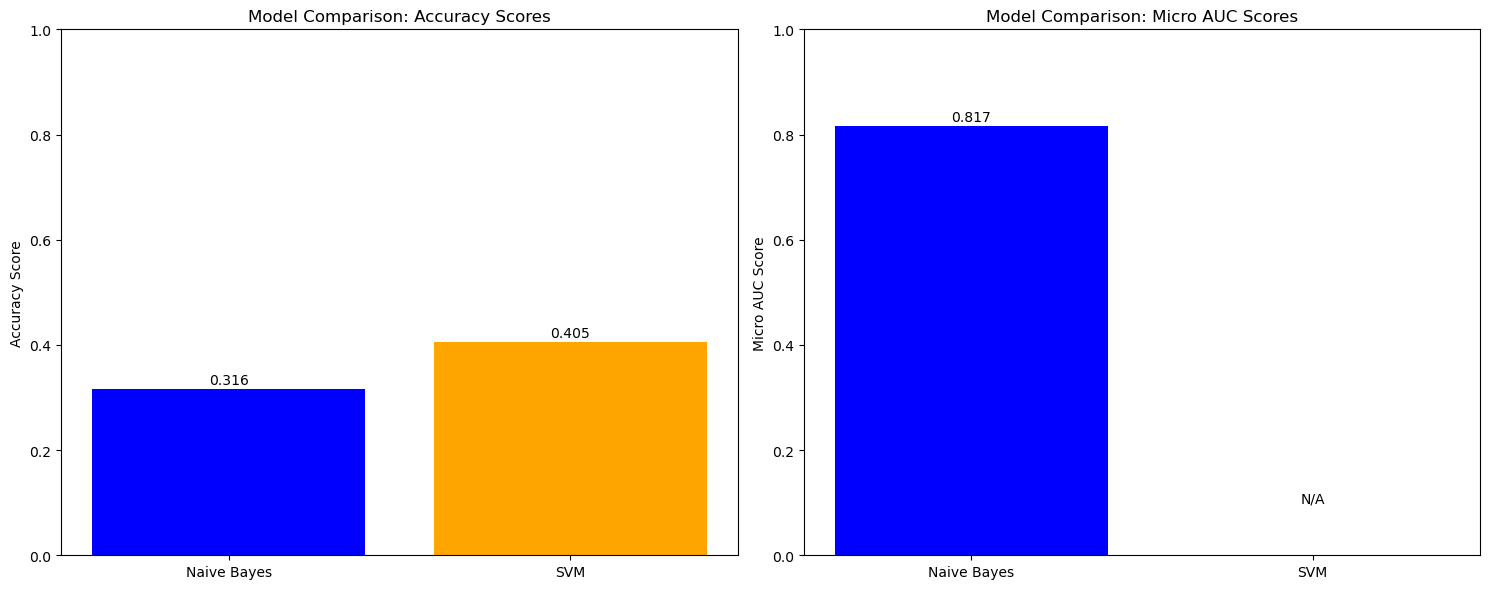

In [9]:
# 9. Comparison of Models
plt.figure(figsize=(12, 6))
model_names = list(results.keys())
micro_auc_scores = []
accuracy_scores = []

for name in model_names:
    y_pred = results[name]['y_pred']
    y_pred_proba = results[name]['y_pred_proba']
    
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
    # Only calculate AUC for models that support it
    if y_pred_proba is not None:
        try:
            micro_auc = roc_auc_score(y_test, y_pred_proba, average='micro')
            micro_auc_scores.append(micro_auc)
        except:
            micro_auc_scores.append(0)
    else:
        micro_auc_scores.append(0)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot Accuracy
bars1 = ax1.bar(model_names, accuracy_scores, color=['blue', 'orange', 'green'])
ax1.set_title('Model Comparison: Accuracy Scores')
ax1.set_ylabel('Accuracy Score')
ax1.set_ylim(0, 1)
for i, v in enumerate(accuracy_scores):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center')

# Plot AUC
bars2 = ax2.bar(model_names, micro_auc_scores, color=['blue', 'orange', 'green'])
ax2.set_title('Model Comparison: Micro AUC Scores')
ax2.set_ylabel('Micro AUC Score')
ax2.set_ylim(0, 1)
for i, v in enumerate(micro_auc_scores):
    if v > 0:  # Only label if AUC is available
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center')
    else:
        ax2.text(i, 0.1, 'N/A', ha='center')

plt.tight_layout()
plt.show()

In [10]:
# 10. Create a prediction function for demonstration
def predict_toxicity(text, model, vectorizer):
    # Preprocess the text
    processed_text = preprocess_text(text)
    
    # Vectorize
    text_vec = vectorizer.transform([processed_text])
    
    # Predict
    prediction = model.predict(text_vec)
    
    # Try to get probabilities if available
    if hasattr(model, 'predict_proba'):
        prediction_proba = model.predict_proba(text_vec)
    else:
        prediction_proba = None
    
    # Format results
    results = {}
    for i, label in enumerate(target_labels):
        result_item = {
            'prediction': bool(prediction[0, i])
        }
        
        if prediction_proba is not None:
            result_item['probability'] = float(prediction_proba[0, i])
        
        results[label.replace('_bin', '')] = result_item
    
    # Determine if overall toxic
    toxic = any(prediction[0])
    
    return {
        'is_toxic': toxic,
        'breakdown': results
    }

# Enter comments here to test the function
test_comments = [
    "This is a really offensive and insulting comment.",
    "I appreciate your help with this project.",
    "You should be threatened for saying that!"
]

print("\nTesting predictions with all models:")
for comment in test_comments:
    print(f"\nComment: '{comment}'")
    for name, result in results.items():
        model = result['model']
        prediction = predict_toxicity(comment, model, vectorizer)
        print(f"  {name}: {'TOXIC' if prediction['is_toxic'] else 'Not toxic'}")


Testing predictions with all models:

Comment: 'This is a really offensive and insulting comment.'
  Naive Bayes: TOXIC
  SVM: Not toxic

Comment: 'I appreciate your help with this project.'
  Naive Bayes: Not toxic
  SVM: Not toxic

Comment: 'You should be threatened for saying that!'
  Naive Bayes: TOXIC
  SVM: TOXIC


Skipping ROC for SVM - no probability estimates available


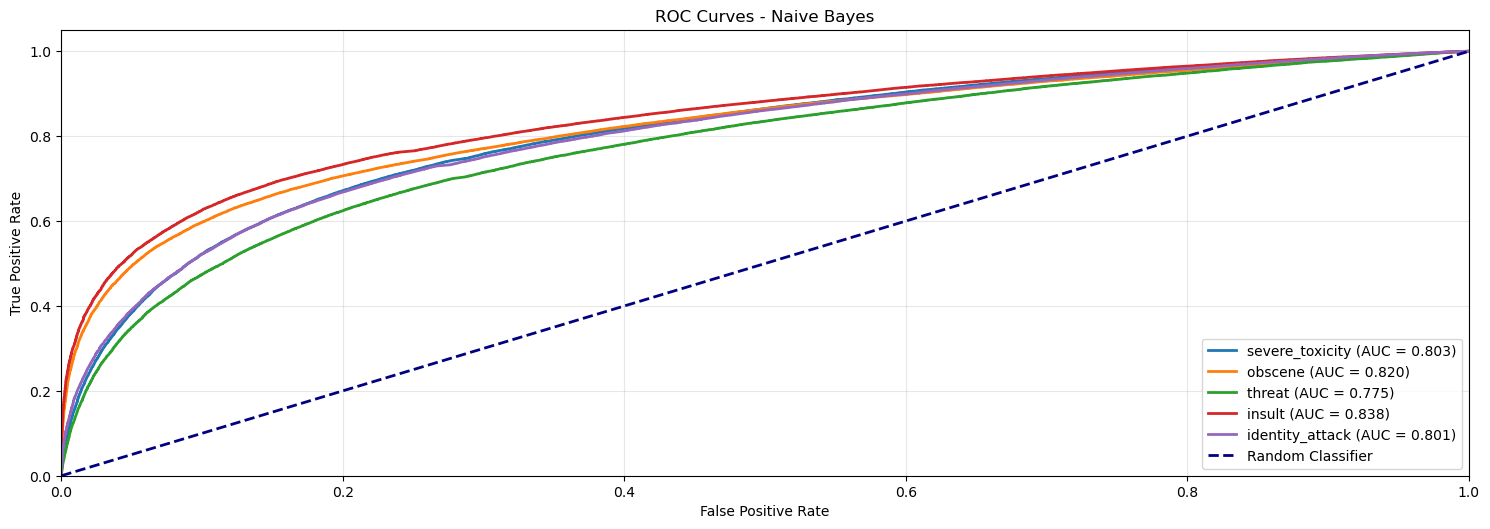

In [11]:
# ROC Curves for each model
plt.figure(figsize=(15, 5 * len(models)))

for i, (model_name, result) in enumerate(results.items()):
    y_pred_proba = result['y_pred_proba']
    
    # Skip models without probability estimates
    if y_pred_proba is None:
        print(f"Skipping ROC for {model_name} - no probability estimates available")
        continue
        
    # Create subplot for each model
    plt.subplot(len(models), 1, i+1)
    
    # Plot ROC curve for each class
    for class_idx, label in enumerate(target_labels):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, class_idx], y_pred_proba[:, class_idx])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.3f})')
    
    # Plot random classifier line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


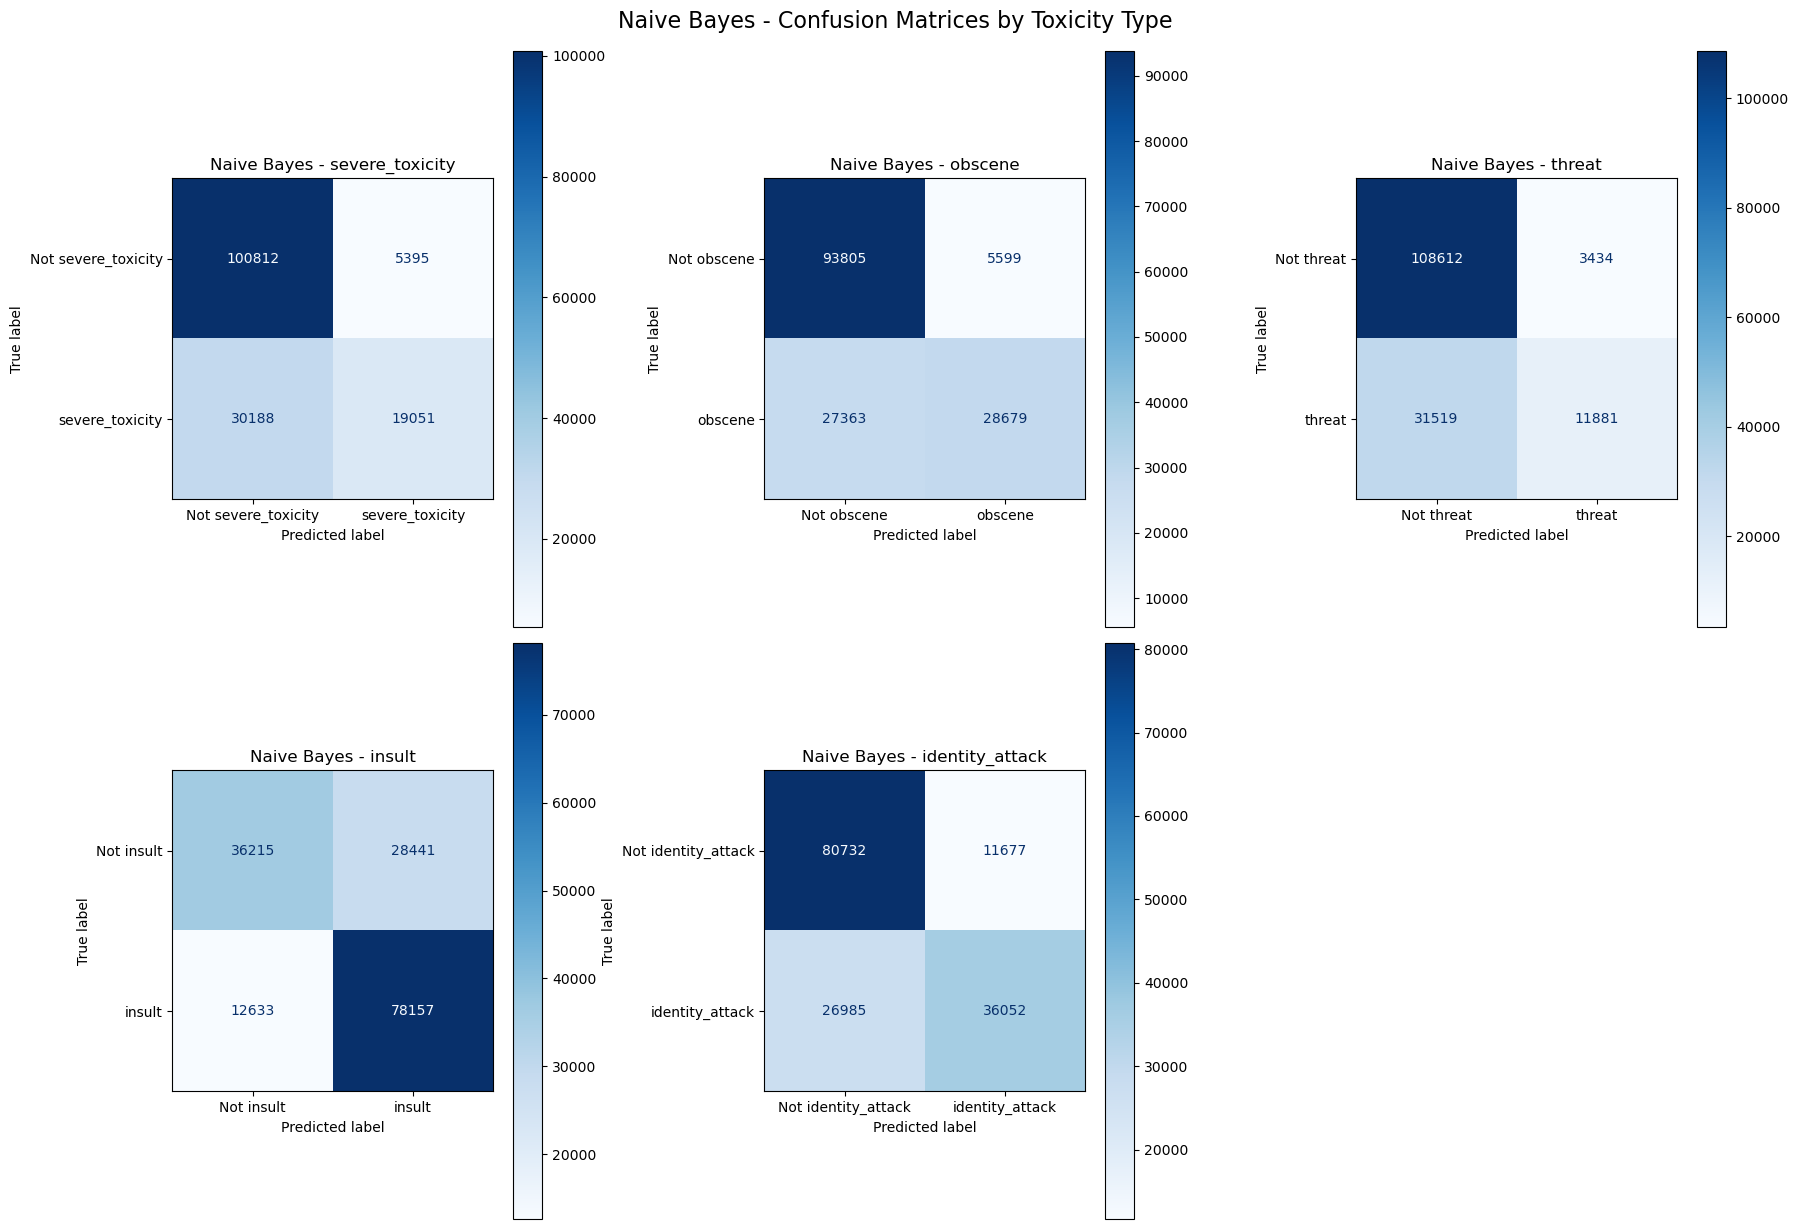

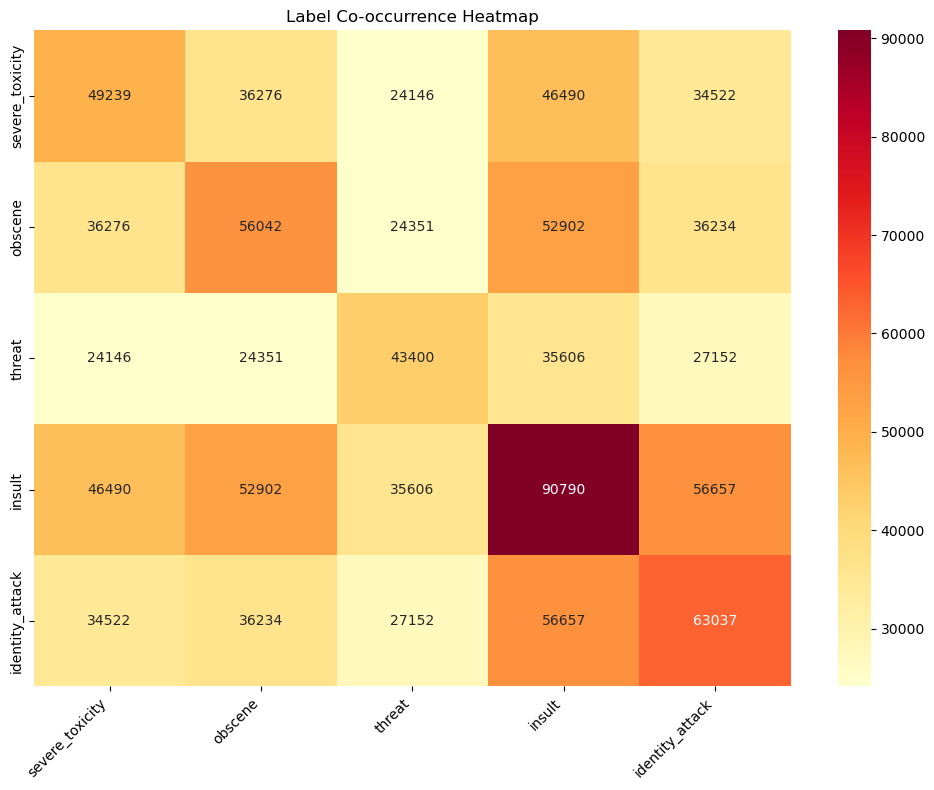

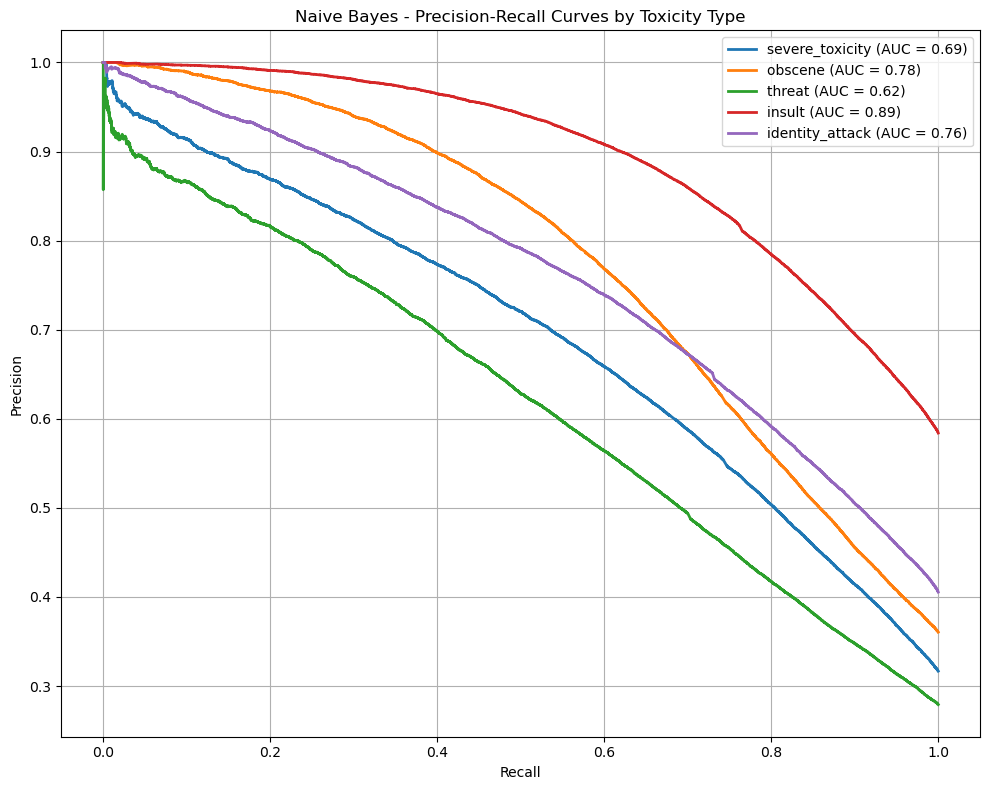

<Figure size 800x600 with 0 Axes>

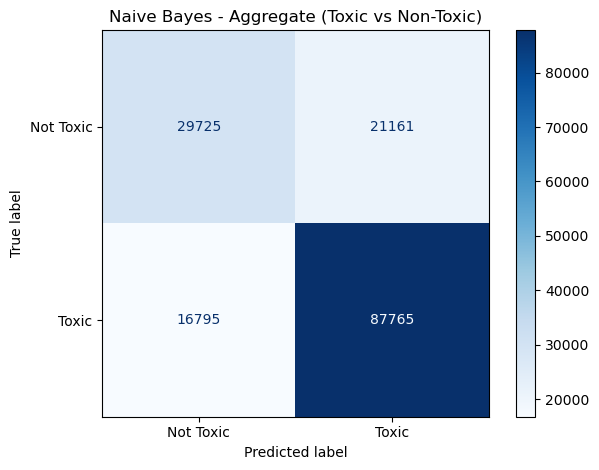

In [12]:
if 'Naive Bayes' in results:
    nb_result = results['Naive Bayes']
    y_pred = nb_result['y_pred']
    
    # Create confusion matrices for each class
    n_classes = len(target_labels)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for class_idx, label in enumerate(target_labels):
        # Calculate confusion matrix
        cm = confusion_matrix(y_test.iloc[:, class_idx], y_pred[:, class_idx])
        
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                     display_labels=[f'Not {label}', label])
        disp.plot(ax=axes[class_idx], cmap='Blues', values_format='d')
        axes[class_idx].set_title(f'Naive Bayes - {label}')

    # Remove any empty subplots
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.suptitle('Naive Bayes - Confusion Matrices by Toxicity Type', fontsize=16, y=1.02)
    plt.show()
    
    # Create label co-occurrence heatmap
    plt.figure(figsize=(10, 8))
    
    # Calculate co-occurrence matrix
    co_occurrence = y_test.T.dot(y_test)
    
    # Create heatmap
    sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlOrRd', 
                xticklabels=target_labels, yticklabels=target_labels)
    plt.title('Label Co-occurrence Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Create Precision-Recall curves for each class
    plt.figure(figsize=(10, 8))
    
    # Check if we have probability estimates for PR curves
    has_proba = 'y_pred_proba' in nb_result and nb_result['y_pred_proba'] is not None
    
    if has_proba:
        for class_idx, label in enumerate(target_labels):
            precision, recall, _ = precision_recall_curve(
                y_test.iloc[:, class_idx], 
                nb_result['y_pred_proba'][:, class_idx]
            )
            
            # Calculate AUC
            pr_auc = auc(recall, precision)
            
            plt.plot(recall, precision, lw=2, label=f'{label} (AUC = {pr_auc:.2f})')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Naive Bayes - Precision-Recall Curves by Toxicity Type')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Note: Probability estimates not available for Naive Bayes. Skipping PR curves.")
    
    # Create aggregate confusion matrix (toxic vs non-toxic)
    plt.figure(figsize=(8, 6))
    
    # Create binary labels: 1 if any toxicity, 0 otherwise
    y_test_toxic = (y_test.sum(axis=1) > 0).astype(int)
    y_pred_toxic = (y_pred.sum(axis=1) > 0).astype(int)
    
    # Calculate aggregate confusion matrix
    agg_cm = confusion_matrix(y_test_toxic, y_pred_toxic)
    
    # Display aggregate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=agg_cm, 
                                 display_labels=['Not Toxic', 'Toxic'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Naive Bayes - Aggregate (Toxic vs Non-Toxic)')
    
    plt.tight_layout()
    plt.show()
        
else:
    print("Naive Bayes model not found in results")

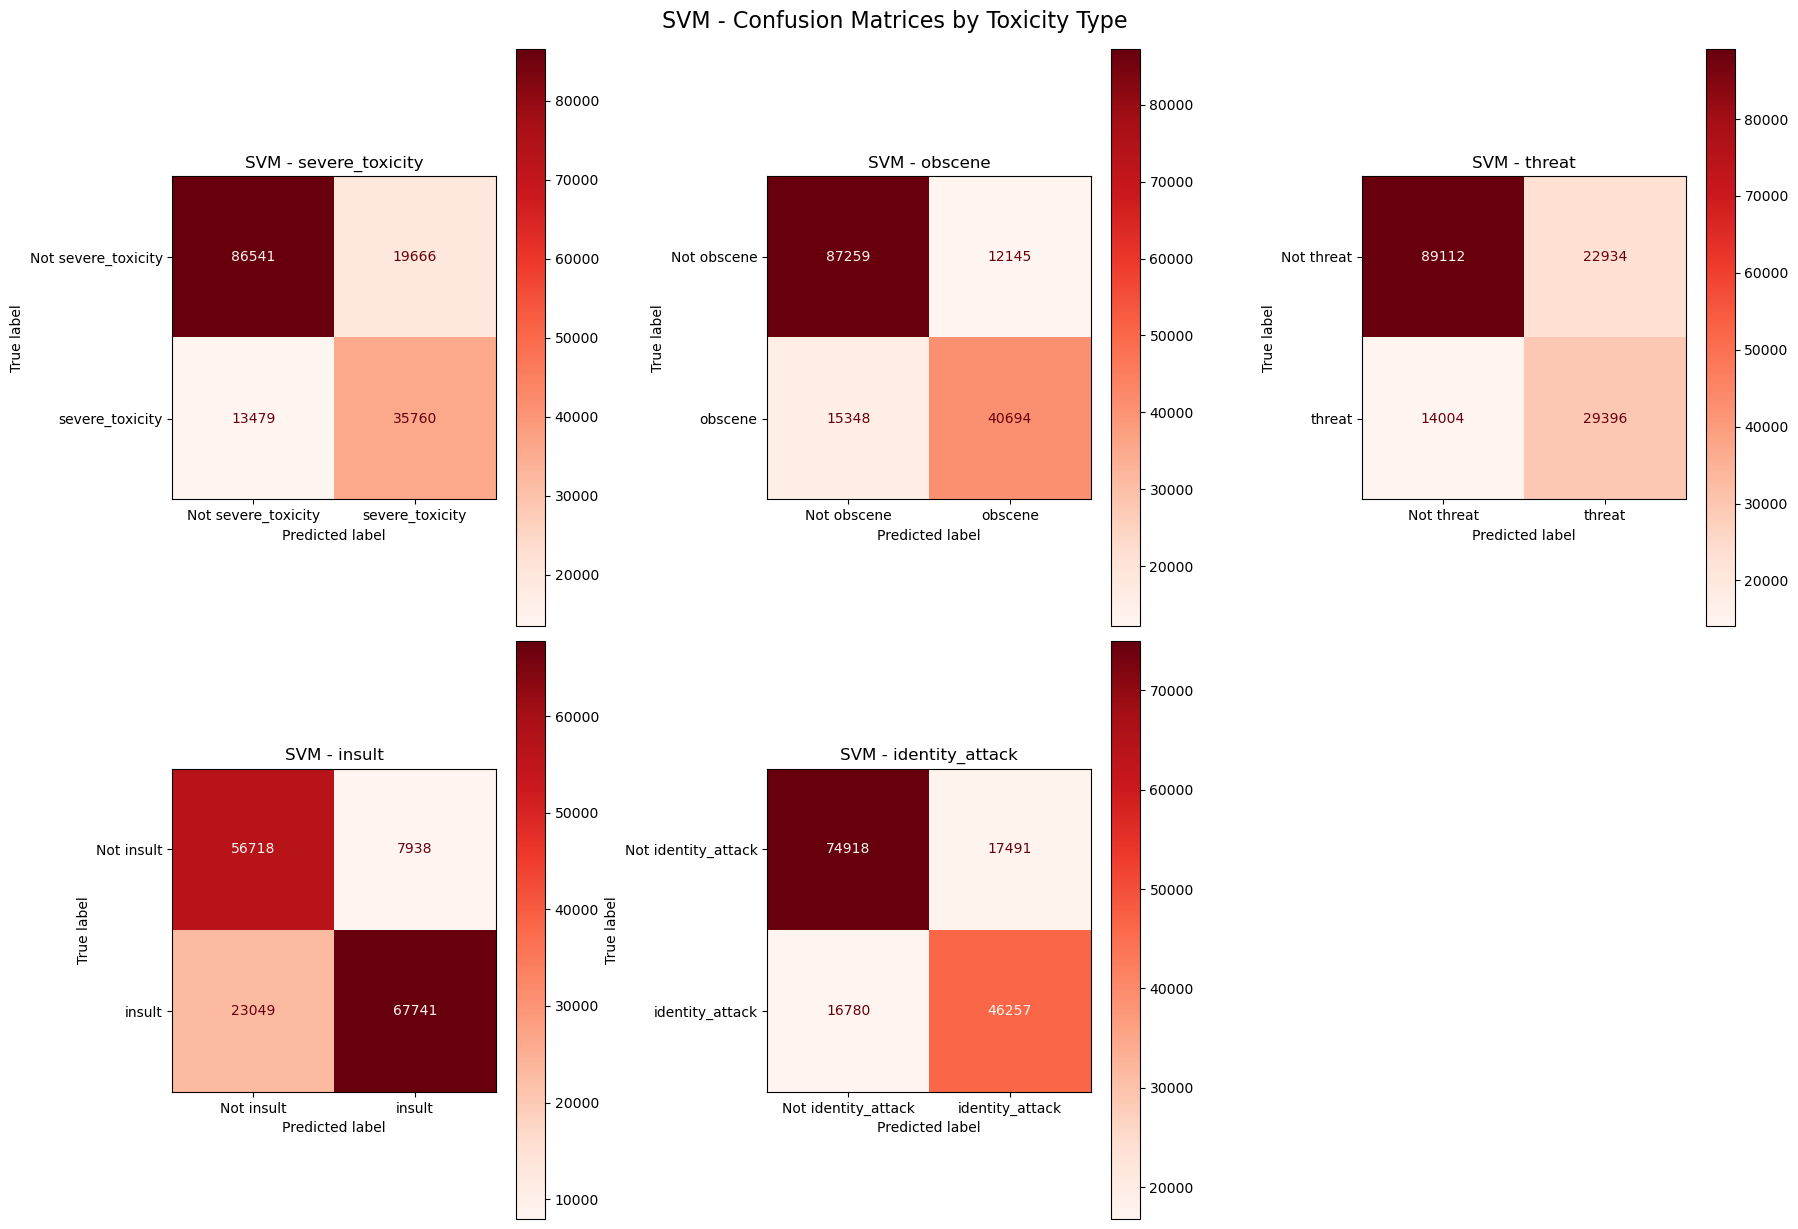

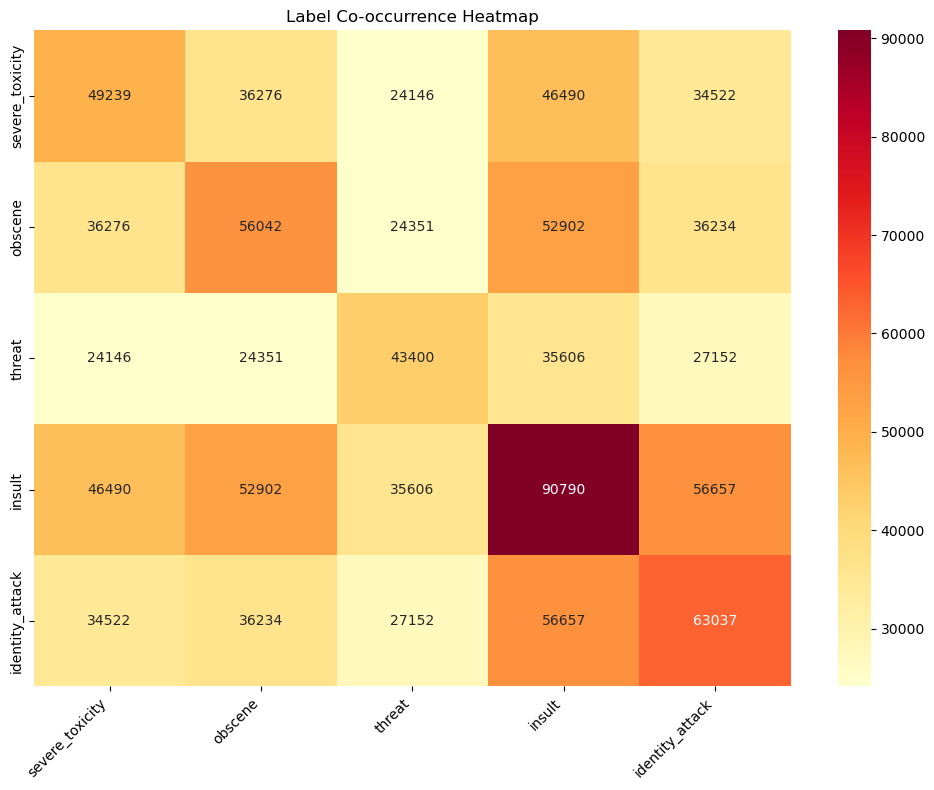

Note: Probability estimates not available for SVM. Skipping PR curves.


<Figure size 800x600 with 0 Axes>

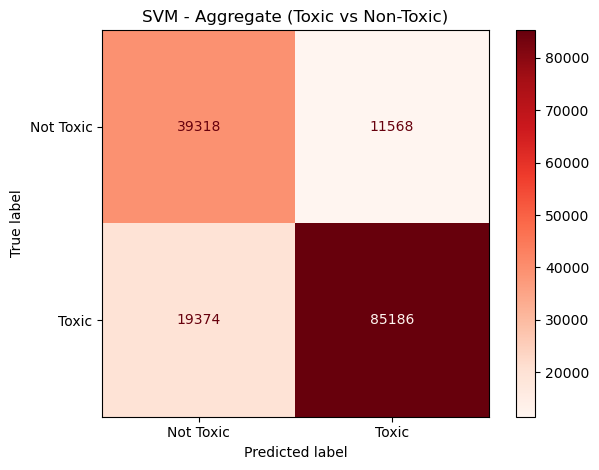

In [13]:
if 'SVM' in results:
    svm_result = results['SVM']
    y_pred = svm_result['y_pred']
    
    # Create confusion matrices for each class
    n_classes = len(target_labels)
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for class_idx, label in enumerate(target_labels):
        # Calculate confusion matrix
        cm = confusion_matrix(y_test.iloc[:, class_idx], y_pred[:, class_idx])
        
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                     display_labels=[f'Not {label}', label])
        disp.plot(ax=axes[class_idx], cmap='Reds', values_format='d')
        axes[class_idx].set_title(f'SVM - {label}')
    
    # Remove any empty subplots
    for i in range(n_classes, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.suptitle('SVM - Confusion Matrices by Toxicity Type', fontsize=16, y=1.02)
    plt.show()
    
    # Create label co-occurrence heatmap
    plt.figure(figsize=(10, 8))
    
    # Calculate co-occurrence matrix
    co_occurrence = y_test.T.dot(y_test)
    
    # Create heatmap
    sns.heatmap(co_occurrence, annot=True, fmt='d', cmap='YlOrRd', 
                xticklabels=target_labels, yticklabels=target_labels)
    plt.title('Label Co-occurrence Heatmap')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # Check if we have probability estimates for PR curves
    has_proba = 'y_pred_proba' in svm_result and svm_result['y_pred_proba'] is not None
    
    if has_proba:
        # Create Precision-Recall curves for each class
        plt.figure(figsize=(10, 8))
        
        for class_idx, label in enumerate(target_labels):
            precision, recall, _ = precision_recall_curve(
                y_test.iloc[:, class_idx], 
                svm_result['y_pred_proba'][:, class_idx]
            )
            
            # Calculate AUC
            pr_auc = auc(recall, precision)
            
            plt.plot(recall, precision, lw=2, label=f'{label} (AUC = {pr_auc:.2f})')
        
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curves by Toxicity Type')
        plt.legend(loc='best')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Note: Probability estimates not available for SVM. Skipping PR curves.")
    
    # Create aggregate confusion matrix (toxic vs non-toxic)
    plt.figure(figsize=(8, 6))
    
    # Create binary labels: 1 if any toxicity, 0 otherwise
    y_test_toxic = (y_test.sum(axis=1) > 0).astype(int)
    y_pred_toxic = (y_pred.sum(axis=1) > 0).astype(int)
    
    # Calculate aggregate confusion matrix
    agg_cm = confusion_matrix(y_test_toxic, y_pred_toxic)
    
    # Display aggregate confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=agg_cm, 
                                 display_labels=['Not Toxic', 'Toxic'])
    disp.plot(cmap='Reds', values_format='d')
    plt.title('SVM - Aggregate (Toxic vs Non-Toxic)')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("SVM model not found in results")